## Imports

In [1]:
import glob
import sys
import os
import re

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import umap
import pickle
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from IPython.display import Image, display
from scipy.stats import hmean
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.metrics import confusion_matrix, fowlkes_mallows_score

%config Completer.use_jedi = False
RANDOM_STATE = 40 # used for reproducibility of all graphs and metrics

## Ingest Data

#### Establish Paths

In [2]:
root_path = # replace with your root path
celeb_path = os.path.join(root_path, 'img_align_celeba')
id_path = os.path.join(root_path, 'identity_CelebA.txt')
processed_path = os.path.join(root_path, 'processed')

#### Definitions

In [3]:
def ingest_metric_data(processed_path, id_path, max_return=10000, from_pickle=False):
    metric_data_paths = glob.glob(os.path.join(processed_path, '*.csv'))
    id_df = pd.read_csv(id_path, sep=' ', names=['image', 'id'])
    
    if not from_pickle:
        get_metric_from_csv(metric_data_paths=metric_data_paths, max_return=max_return, id_df=id_df)
    
    metric_df = get_metric_from_pickle()
    
    return metric_data_paths, metric_df, id_df

def get_metric_from_pickle():
    pickle_file_names = glob.glob('*.pkl')
    
    subset_li = []
    for name in pickle_file_names:
        with open(name, 'rb') as f:
            subset_li.append(pickle.load(f))
    
    metric_df = pd.concat(subset_li, ignore_index=True)
    
    return metric_df

def get_metric_from_csv(metric_data_paths, id_df, max_return=10000):
    
    if str.lower(str(max_return))=='max':
        max_return = len(metric_data_paths)
    
    subset = 0
    df_li = []
    for i, path in tqdm(enumerate(metric_data_paths[0:max_return]), total=max_return):
        df = pd.read_csv(path)
        image = path.split('\\')[-1][:-4] + '.jpg'
        df['image'] = image
        df['id'] = int(id_df[id_df['image'] == image]['id'])
        df_li.append(df)
        
        # partition total data ingest to subset pickles
        if (i+1)%20000 == 0:
            metric_df = pd.concat(df_li, ignore_index=True)
            
            with open(f'metric_df_{subset}.pkl', 'wb') as f:
                pickle.dump(metric_df, f)
                del metric_df
                subset += 1
            df_li = []
    
    if df_li:
        metric_df = pd.concat(df_li, ignore_index=True)
        with open(f'metric_df_{subset}.pkl', 'wb') as f:
            pickle.dump(metric_df, f)

#### Load Data

In [4]:
metric_data_paths, metric_df, id_df = ingest_metric_data(processed_path=processed_path, id_path=id_path,
                                                         max_return='max', from_pickle=True)

#### Drop Duplicates, Low Confidence, and Clean Columns

Below, all images that are respresented twice (specifically, OpenFace found two different faces in a single image) are dropped. CelebA is meant to contain an image of a single subject, but there are several hundred that contain a background subject. A majority of these images obtain low confidence scores on OpenFace's fit on at least one of the subjects, so we decided to drop all of them since the number of images containing multiple subjects is negligible compared to the total size of the dataset.

We then decided to drop all images that did not receive OpenFace's highest confidence score (0.975) as these contain the fewest pose and spatial fit errors on OpenFace's part. Even after dropping these images, the resulting dataset still contains over 75% of the original images and over 10,000 unique identities. Of these remaining identities, there are still 59 identities which are still highly represented by 30 images each. The distribution of representitive images for frequency of unique IDs may be viewed below.

In [5]:
drop_li = metric_df['image'].value_counts()[metric_df['image'].value_counts() >= 2].keys().to_list()
metric_df = metric_df[~metric_df['image'].isin(drop_li)].reset_index(drop=True)
metric_df.columns = metric_df.columns.str.replace(' ', '')
metric_df = metric_df.drop(columns=['face'])
metric_df = metric_df[metric_df['confidence'] == 0.975].reset_index(drop=True)

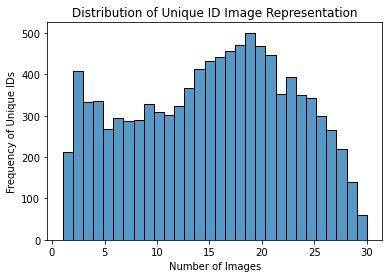

In [6]:
sns.histplot(metric_df['id'].value_counts().to_list(), bins=30)
plt.title('Distribution of Unique ID Image Representation')
plt.xlabel('Number of Images')
plt.ylabel('Frequency of Unique IDs')
plt.show()

## Studies

#### Definitions

In [7]:
def display_images(path, image_list):
    image_path_list = [os.path.join(path, image) for image in image_list]
    
    for path in image_path_list:
        display(Image(filename=path))
        
def get_spatial_metrics(metric_df):
    cols = metric_df.columns.to_list()
    cols = [re.findall('(.*[xyz]_\d+)', col) for col in cols]
    spatial_cols = [col[0] for col in cols if col]
    spatial_df = metric_df[spatial_cols]
    
    return spatial_df

def get_shape_metrics(metric_df):
    cols = metric_df.columns.to_list()
    cols = [re.findall('p_.*', col) for col in cols]
    shape_cols = [col[0] for col in cols if col]
    shape_df = metric_df[shape_cols]
    
    return shape_df

def get_top_n_most_represented(metric_df, N=10):
    most_rep = metric_df['id'].value_counts().keys().to_list()[:N]
    most_rep_df = metric_df[metric_df['id'].isin(most_rep)].reset_index(drop=True)
    
    return most_rep_df

def cosine_sim(A, B):
    cos_sim = np.dot(A, B)/(np.linalg.norm(A)*np.linalg.norm(B))

    return cos_sim

def performance(df, scaled_data):
    retrieve_num = int(np.floor(df.shape[0]*0.05)) # alpha=0.05 significance test
    perf_df = pd.DataFrame(columns=['id', 'euclidean_f1', 'euclidean_metrics', 'cosine_f1', 'cosine_metrics'], 
                           index=range(scaled_data.shape[0]))
    
    for i, sample in tqdm(enumerate(scaled_data), total=scaled_data.shape[0]):
        face_id = df['id'][i]
        perf_df['id'][i] = face_id
        
        sample_scaled_data = np.delete(scaled_data, i, axis=0) # remove current facial vector
        cos_sim = np.array([cosine_sim(sample, face_vec) for face_vec in sample_scaled_data])
        euclidean_sim = np.array([np.linalg.norm(sample - face_vec) for face_vec in sample_scaled_data])
        closest_cosine_idxs = retrieve_n_closest(similarty_list=cos_sim, closeness='max', N=retrieve_num)
        closest_euclidean_idxs = retrieve_n_closest(similarty_list=euclidean_sim, closeness='min', N=retrieve_num)
        perf_df['cosine_metrics'][i] = calculate_f1_metrics(closest_idxs=closest_cosine_idxs,
                                                            face_id=face_id, df=df)
        perf_df['cosine_f1'][i] = perf_df['cosine_metrics'][i]['f1']
        perf_df['euclidean_metrics'][i] = calculate_f1_metrics(closest_idxs=closest_euclidean_idxs,
                                                               face_id=face_id, df=df)
        perf_df['euclidean_f1'][i] = perf_df['euclidean_metrics'][i]['f1']
    
    return perf_df
               

def retrieve_n_closest(similarty_list, closeness, N):
    assert type(closeness) == str
    assert N <= int(np.floor(len(similarty_list)*0.05)) + 1 # +1 accounting for deleted vector 
    
    if closeness == 'max':
        closest_idxs = np.argpartition(similarty_list, -N)[-N:]
        sorted_closest_idxs = closest_idxs[np.argsort(similarty_list[closest_idxs])][::-1] # want largest->smallest
    elif closeness == 'min':
        closest_idxs = np.argpartition(similarty_list, N)[:N]
        sorted_closest_idxs = closest_idxs[np.argsort(similarty_list[closest_idxs])]
        
    return sorted_closest_idxs

def calculate_f1_metrics(closest_idxs, face_id, df):
    retrieve_num = closest_idxs.shape[0]
    
    total_true = df[df['id'] == face_id].shape[0]
    TP = sum(df.iloc[closest_idxs]['id'] == face_id)
    if total_true > retrieve_num:
        total_true = retrieve_num # cannot have more true than are returned
    elif TP == total_true:
        retrieve_num = df[df.iloc[closest_idxs]['id'] == face_id].index.to_list()[-1]
        print(retrieve_num)
    
    assert total_true >= TP
    FP = retrieve_num - TP
    FN = total_true - TP
    precision = TP/(TP + FP)
    recall = TP/(TP + FN)
    if precision == 0.0 or recall == 0.0:
        f1 = 0.0
    else:
        f1 = 2*(precision*recall)/(precision + recall)
        
    return {'TP': TP, 'FP': FP, 'FN': FN, 'precision': precision, 'recall': recall, 'f1': f1}

def get_mean_f1(perf_metric_series):
    TP_tot = 0
    FP_tot = 0
    FN_tot = 0
    
    for metric in perf_metric_series:
        TP_tot += metric['TP']
        FP_tot += metric['FP']
        FN_tot += metric['FN']
    
    mean_prec = TP_tot/(TP_tot + FP_tot)
    mean_recall = TP_tot/(TP_tot + FN_tot)
    mean_f1 = (mean_prec*mean_recall)/(mean_prec + mean_recall)
    
    return mean_f1

### Study 0: Visualizing the Feature Space

Here we visually explore the shape and separability of the dataset's feature space using UMAP. We first look at the full, scaled first 10,000 samples of data on a euclidean and cosine manifold. We chose these two metrics based on the knowledge that the underlying features are largely spatial and through checking the behavior of alternate metrics. Our check of alternate metrics did not produce superior topologies; thus, we will continue to use euclidean and cosine manifolds throughout our studies. Additionally, we chose to observe only the first 10,000 samples because it is highly representative of the topology of the total dataset.

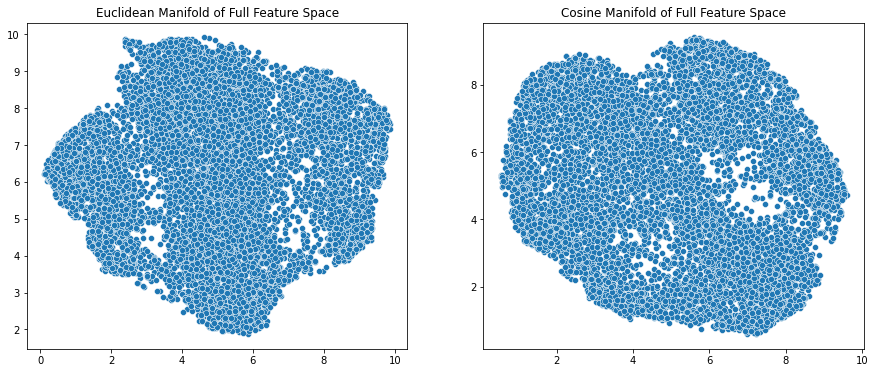

In [8]:
scaled_full_data = StandardScaler().fit_transform(metric_df.drop(columns=['confidence', 'id', 'image']).values[0:10000])

fig, axes = plt.subplots(1, 2, figsize=(15,6))

reducer = umap.UMAP(n_neighbors=25, metric='euclidean', low_memory=False, random_state=RANDOM_STATE)
embedding = reducer.fit_transform(scaled_full_data)
sns.scatterplot(ax=axes[0], x=embedding[:,0], y=embedding[:,1])
axes[0].set_title('Euclidean Manifold of Full Feature Space')

reducer = umap.UMAP(n_neighbors=25, metric='cosine', low_memory=False, random_state=RANDOM_STATE)
embedding = reducer.fit_transform(scaled_full_data)
sns.scatterplot(ax=axes[1], x=embedding[:,0], y=embedding[:,1])
axes[1].set_title('Cosine Manifold of Full Feature Space')

plt.show()

We see well structured (shaped) topologies produced by both the euclidean and cosine metrics; however, the data is largely uniformly distributed over the manifold, indicative of a difficult discriminant (identity recognition) task based on the features produced by OpenFace.

Below, we drop all features outside of eye and facial landmark positions, described [here](https://github.com/TadasBaltrusaitis/OpenFace/wiki/Output-Format), in an effort to isolate purely facial identifying features.

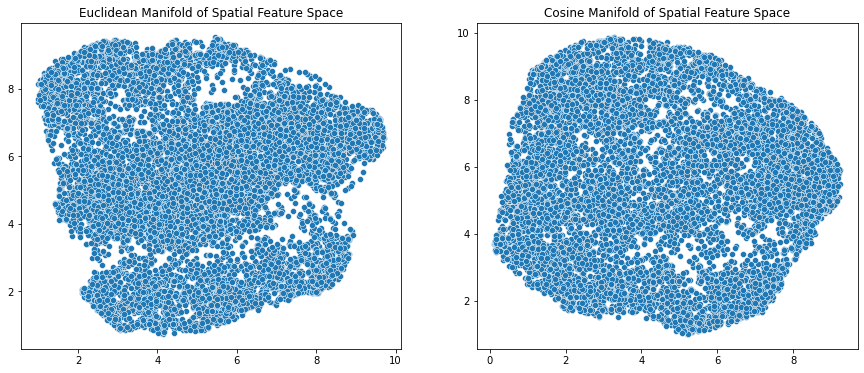

In [9]:
scaled_spatial_data = StandardScaler().fit_transform(get_spatial_metrics(metric_df=metric_df).values[0:10000])

fig, axes = plt.subplots(1, 2, figsize=(15,6))

reducer = umap.UMAP(n_neighbors=25, metric='euclidean', low_memory=False, random_state=RANDOM_STATE)
embedding = reducer.fit_transform(scaled_spatial_data)
sns.scatterplot(ax=axes[0], x=embedding[:,0], y=embedding[:,1])
axes[0].set_title('Euclidean Manifold of Spatial Feature Space')

reducer = umap.UMAP(n_neighbors=25, metric='cosine', low_memory=False, random_state=RANDOM_STATE)
embedding = reducer.fit_transform(scaled_spatial_data)
sns.scatterplot(ax=axes[1], x=embedding[:,0], y=embedding[:,1])
axes[1].set_title('Cosine Manifold of Spatial Feature Space')

plt.show()

We observe that dropping all features outside of eye and facial landmark features does little to change the overall topology of the manifold, indicating we have lost little information, but have gained slight separation in the feature space. Through this oberservation, we will continue to use only the spatial landmark features of the OpenFace dataset.

### Study 1: Similarity Metrics on Full Dimension Spatial Data

In this study we begin by showing the performance of applying cosine and euclidean distance metrics on the full dimensional, scaled, spatial data to return images of the same identity. To help in later visualizations, we limit our study dataset to the top 10 most represented identities in the CelebA dataset. Each identity has 30 representative images for a total of 300 samples in the study dataset. 

Performance is measured on each image through the $F_{1}$-score achieved by analyzing the top-$N$ closest (based on distance metric) images returned. $N$ is determined as 5% of the total size of the dataset to instill an $\alpha=0.05$ level confidence test. For this study in particular, $N=15$ because the dataset contains 300 samples; thus, the $F_1$-score for each image is determined by calculating the true positives (TP), false positives (FP), and false negatives (FN) of the 15 closest images returned.

In [10]:
top_10_df = get_top_n_most_represented(metric_df=metric_df, N=10)
scaled_top_10_data = StandardScaler().fit_transform(get_spatial_metrics(metric_df=top_10_df).values)
top_10_perf_df = performance(df=top_10_df, scaled_data=scaled_top_10_data)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 56.54it/s]


Below we compute the mean $F_1$-score achieved by both similarity metrics. We find that the cosine metric performs insignificantly better than the euclidean metric and that both metrics overall perform poorly in returning images of the same identity. This is unsurprising given the uniformity of the data over the manifold we observed in Study 0.

In [11]:
euclidean_mean_f1 = get_mean_f1(perf_metric_series=top_10_perf_df['euclidean_metrics'])
cosine_mean_f1 = get_mean_f1(perf_metric_series=top_10_perf_df['cosine_metrics'])
print(f'Euclidean Mean F1-score: {euclidean_mean_f1}\nCosine Mean F1-score: {cosine_mean_f1}')

Euclidean Mean F1-score: 0.1388888888888889
Cosine Mean F1-score: 0.14177777777777778


We next look at if the cosine similarity metric (it performing nominally the best) did perform well on any single identity. We find that there is one ID, 4516, that both metrics did achieve a perfect $F_1$-score on, with cosine returning the most images with such a score.

In [12]:
top_10_perf_df[top_10_perf_df['cosine_f1'] == top_10_perf_df['cosine_f1'].max()]

,id,euclidean_f1,euclidean_metrics,cosine_f1,cosine_metrics
271,4516,0.866667,"{'TP': 13, 'FP': 2, 'FN': 2, 'precision': 0.86...",1.0,"{'TP': 15, 'FP': 0, 'FN': 0, 'precision': 1.0,..."
273,4516,1.0,"{'TP': 15, 'FP': 0, 'FN': 0, 'precision': 1.0,...",1.0,"{'TP': 15, 'FP': 0, 'FN': 0, 'precision': 1.0,..."
276,4516,1.0,"{'TP': 15, 'FP': 0, 'FN': 0, 'precision': 1.0,...",1.0,"{'TP': 15, 'FP': 0, 'FN': 0, 'precision': 1.0,..."
278,4516,1.0,"{'TP': 15, 'FP': 0, 'FN': 0, 'precision': 1.0,...",1.0,"{'TP': 15, 'FP': 0, 'FN': 0, 'precision': 1.0,..."
279,4516,1.0,"{'TP': 15, 'FP': 0, 'FN': 0, 'precision': 1.0,...",1.0,"{'TP': 15, 'FP': 0, 'FN': 0, 'precision': 1.0,..."
280,4516,0.933333,"{'TP': 14, 'FP': 1, 'FN': 1, 'precision': 0.93...",1.0,"{'TP': 15, 'FP': 0, 'FN': 0, 'precision': 1.0,..."
283,4516,0.933333,"{'TP': 14, 'FP': 1, 'FN': 1, 'precision': 0.93...",1.0,"{'TP': 15, 'FP': 0, 'FN': 0, 'precision': 1.0,..."
285,4516,1.0,"{'TP': 15, 'FP': 0, 'FN': 0, 'precision': 1.0,...",1.0,"{'TP': 15, 'FP': 0, 'FN': 0, 'precision': 1.0,..."
288,4516,0.933333,"{'TP': 14, 'FP': 1, 'FN': 1, 'precision': 0.93...",1.0,"{'TP': 15, 'FP': 0, 'FN': 0, 'precision': 1.0,..."
289,4516,1.0,"{'TP': 15, 'FP': 0, 'FN': 0, 'precision': 1.0,...",1.0,"{'TP': 15, 'FP': 0, 'FN': 0, 'precision': 1.0,..."


To visualize this increase in performance, we map the top 10 dataset to a two dimensional manifold as we did before using a cosine metric. We immediately observe that ID 4516 does obtain large seperation from the rest of the data distibuted on the manifold. In agreeance with our previous findings in Study 0, we also find that a majority of the remaining IDs do exhibit very little inter-ID clustering and are largely intermixed providing insight into the poor $F_1$-scores obtained by either metric. 

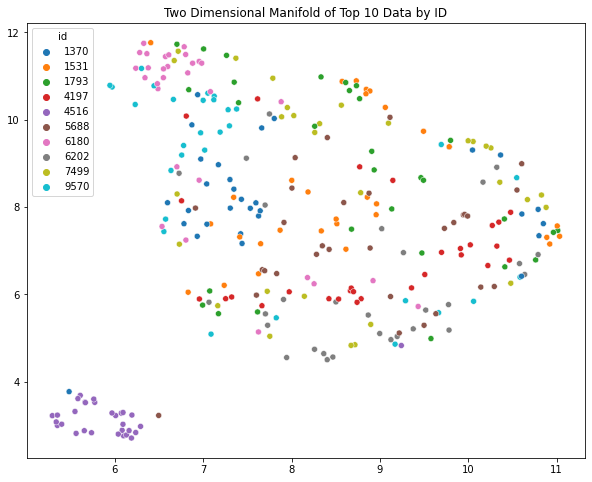

In [13]:
reducer = umap.UMAP(n_neighbors=25, metric='cosine', low_memory=False, random_state=RANDOM_STATE)
embedding = reducer.fit_transform(scaled_top_10_data)
fig, axes = plt.subplots(1, 1, figsize=(10,8))
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=top_10_df['id'], palette=sns.color_palette())
plt.title('Two Dimensional Manifold of Top 10 Data by ID')
plt.show()

### Study 2: Similarity Metrics on Compressed Data

The performance of the similarity metrics on verifying images containing the same identities through using OpenFace's full spatial feature set left much to be desired. Next we will study if we receive increased performance when we compare images lying on a lower dimensional manifold. We first begin by fitting our top 10 data from Study 1 with a simple PCA compression to get an insight on the natural dimension, $N$, of the manifold the data may lie on. We do this through observing the total explained variance over $N$ principle components and determine the lowest acceptable $N$ to be the value which provides at least 90% of the variance explained. This results in a value of $N=6$.

In [14]:
top_10_pca = PCA().fit(get_spatial_metrics(metric_df=top_10_df).values)
components_kept = 6
var_explained = sum(top_10_pca.explained_variance_ratio_[0:components_kept])
print(f'Ratio of explained variance over {components_kept} principle components kept: {var_explained}')

Ratio of explained variance over 6 principle components kept: 0.9264041138097263


We now fit the top 10 data onto a six dimensional manifold using a cosine metric through UMAP. Afterwards, we calculate the performance for both similarity metrics as we did in Study 1 on the resultant scaled, UMAP embeddings and report the mean $F_1$-scores achieved by either metric. We find that the compressed embeddings result in both metrics performing worse overall. Indicating that compressing the data to an underlying manifold did not assist in improving the linear separation over the data distribution and, further that the underlying data distibution is highly non-linear. 

In [15]:
reducer = umap.UMAP(n_neighbors=25, metric='cosine', min_dist=0.0, n_components=components_kept, 
                    low_memory=False, random_state=RANDOM_STATE)
embedding = reducer.fit_transform(scaled_top_10_data)
scaled_embedding = StandardScaler().fit_transform(embedding)
perf_df_6_dim = performance(df=top_10_df, scaled_data=scaled_embedding)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 53.72it/s]


In [16]:
euclidean_mean_f1_6_dim = get_mean_f1(perf_metric_series=perf_df_6_dim['euclidean_metrics'])
cosine_mean_f1_6_dim = get_mean_f1(perf_metric_series=perf_df_6_dim['cosine_metrics'])
print(f'Euclidean Mean F1-score: {euclidean_mean_f1_6_dim}\nCosine Mean F1-score: {cosine_mean_f1_6_dim}')

Euclidean Mean F1-score: 0.13755555555555554
Cosine Mean F1-score: 0.13177777777777777


### Study 3: Clustering on Full and Compressed Data

#### Definitions

In [17]:
def assign_true_clusters(feature_df, pred_labels):
    feature_df = feature_df.copy()
    
    true_ids = feature_df['id'].unique()
    cluster_labels = np.unique(pred_labels)
    feature_df['pred_cluster'] = pred_labels
    
    cluster_freq_df = pd.DataFrame()
    for true_id in true_ids:
        cluster_s = pd.Series(data=np.zeros(true_ids.shape[0], dtype=int), index=cluster_labels)
        cluster_count = feature_df[feature_df['id'] == true_id]['pred_cluster'].value_counts()
        cluster_s[cluster_count.index] = cluster_count.values
        cluster_freq_df[str(true_id)] = cluster_s
    
    true_clusters = np.full(feature_df.shape[0], np.nan)
    for i in range(cluster_freq_df.shape[0]):
        max_count_id = cluster_freq_df.max(axis=0)[cluster_freq_df.max(axis=0) == 
                                                        cluster_freq_df.max(axis=0).max()].index[0]
        max_count_cluster = cluster_freq_df[max_count_id][cluster_freq_df[max_count_id] == 
                                                          cluster_freq_df[max_count_id].max()].index[0]
        feature_df_id_indxs = feature_df[feature_df['id'] == int(max_count_id)].index.to_list()
        true_clusters[feature_df_id_indxs] = max_count_cluster
        cluster_freq_df = cluster_freq_df.drop(index=max_count_cluster, columns=max_count_id)
        
    
    feature_df['true_cluster'] = true_clusters.astype(int)
    feature_df = determine_correct_labels(feature_df=feature_df)
    
    return feature_df

def determine_correct_labels(feature_df):
    correct_labels = np.full(feature_df.shape[0], 0)
    correct_label_indxs = feature_df[feature_df['pred_cluster'] == feature_df['true_cluster']].index.to_list()
    correct_labels[correct_label_indxs] = 1
    feature_df['correct_cluster'] = correct_labels
    
    return feature_df

#### Spectral Clustering on Full Spatial Features

Given our findings in Study 0 and Study 2, it is apparent that the underlying data distribution of the features produced by OpenFace are highly non-linear. Thus, linear distance metrics such as euclidean and cosine similarity will perform poorly. In response, here we study the performance of using spectral clustering, one of the most highly non-linear similarity methods, for grouping images of similar identity based on the full and compressed set of OpenFace's features. 

We begin by studying the performance of spectrally clustering the data on the full spatial feature space. Performance here will not be measured through $F_1$-score as it is a poor metric for cluster assignment data, but through the [Fowlkes-Mallows index](https://en.wikipedia.org/wiki/Fowlkes%E2%80%93Mallows_index), ($FMI$), which is a highly robust and synonymously interperable metric.

In [18]:
spectral_model = SpectralClustering(n_clusters=10, affinity='nearest_neighbors', random_state=RANDOM_STATE)
spectral_full_fit = spectral_model.fit(scaled_top_10_data)

In [19]:
spectral_full_df = assign_true_clusters(feature_df=top_10_df, pred_labels=spectral_full_fit.labels_)

In [20]:
full_fmi = fowlkes_mallows_score(labels_pred=spectral_full_df['pred_cluster'], 
                                 labels_true=spectral_full_df['true_cluster'])
print(f'FMI on Full Spatial Features: {full_fmi}')

FMI on Full Spatial Features: 0.3334461360645224


Spectral clustering over doubles the quality of our performance on our identification task compared to our previous linear methods, but still overall performs poorly in true identification quality. To visualize our results, we map our top 10 data back to a two dimensional space using UMAP and display our clustering quality. We observe that for several IDs we are able to recover most of the representative images. However, we still see large mixing (folding) of the data into serparate clusters. In an effort to disentagle the feature space, we will once again project the data onto a six dimensional manifold as we did before and test if the performance of our spectral clustering methodology is increased.

In [21]:
scaled_spectral_full = StandardScaler().fit_transform(get_spatial_metrics(metric_df=spectral_full_df).values)
reducer = umap.UMAP(n_neighbors=25, metric='cosine', low_memory=False, random_state=RANDOM_STATE)
embedding = reducer.fit_transform(scaled_spectral_full)

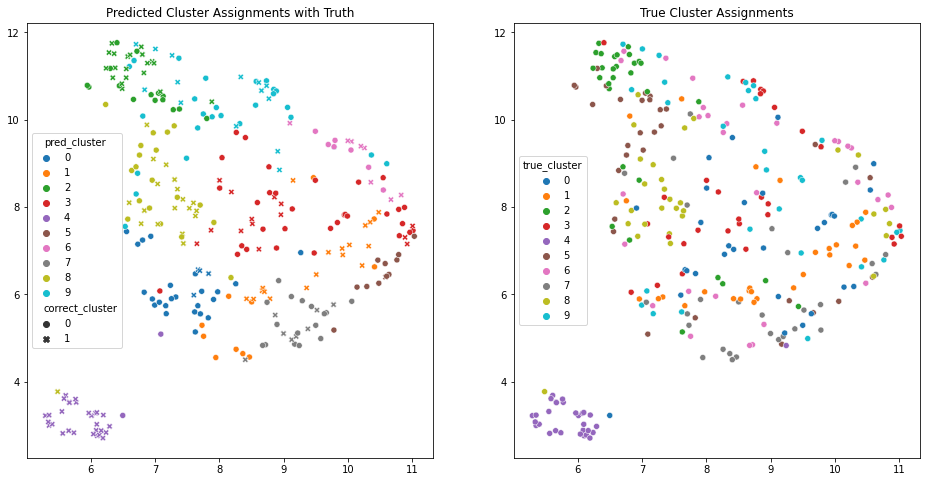

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))
sns.scatterplot(ax=axes[0], x=embedding[:,0], y=embedding[:,1], hue=spectral_full_df['pred_cluster'], 
                style=spectral_full_df['correct_cluster'], palette=sns.color_palette())
sns.scatterplot(ax=axes[1], x=embedding[:,0], y=embedding[:,1], hue=spectral_full_df['true_cluster'], 
                palette=sns.color_palette())
axes[0].set_title('Predicted Cluster Assignments with Truth')
axes[1].set_title('True Cluster Assignments')
plt.show()

#### Spectral Clustering on Compressed Spatial Features

We observe the same degredation in performance with spectral clustering as we did with our linear methods with the lower dimensional space, indicating that the feature space generated by OpenFace is highly complex and receives no increase in expressive quality on a lower dimensional manifold. Given the feature space's complex nature, much more powerful supervised, discriminative models would need to be employed to receive increased identification performance. Ultimatley, from the studies we have conducted here, the feature space generated by OpenFace appears to construct a topology that is not discriminately expressive toward unique facial features. 

In [23]:
reducer = umap.UMAP(n_neighbors=25, metric='euclidean', min_dist=0.0, n_components=components_kept, 
                    low_memory=False, random_state=RANDOM_STATE)
embedding = reducer.fit_transform(scaled_top_10_data)
scaled_embedding = StandardScaler().fit_transform(embedding)

spectral_model = SpectralClustering(n_clusters=10, affinity='nearest_neighbors', random_state=RANDOM_STATE)
spectral_6_dim_fit = spectral_model.fit(scaled_embedding)
spectral_6_dim_df = assign_true_clusters(feature_df=top_10_df, pred_labels=spectral_6_dim_fit.labels_)
compressed_fmi = fowlkes_mallows_score(labels_pred=spectral_6_dim_df['pred_cluster'], 
                                       labels_true=spectral_6_dim_df['true_cluster'])
print(f'FMI on Compressed Spatial Features: {compressed_fmi}')

FMI on Compressed Spatial Features: 0.28966346267716075


In [24]:
reducer = umap.UMAP(n_neighbors=25, metric='cosine', low_memory=False, random_state=RANDOM_STATE)
embedding = reducer.fit_transform(scaled_top_10_data)

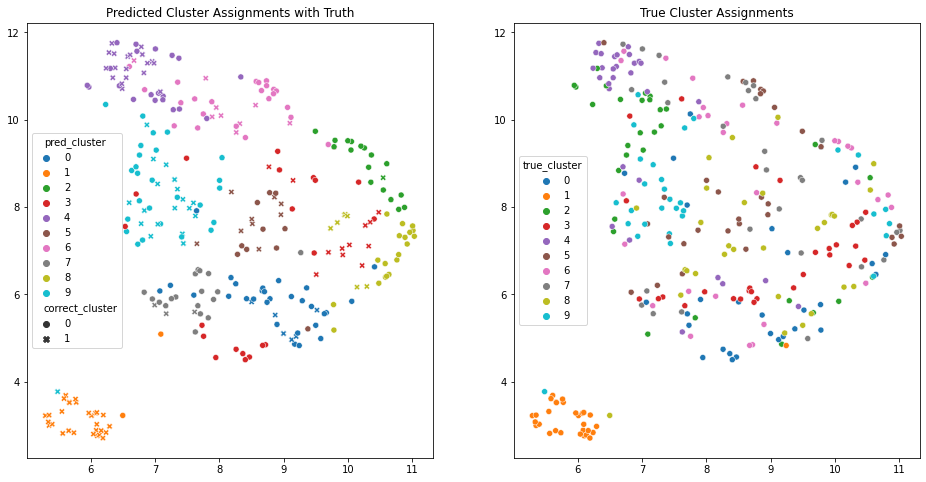

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))
sns.scatterplot(ax=axes[0], x=embedding[:,0], y=embedding[:,1], hue=spectral_6_dim_df['pred_cluster'], 
                style=spectral_6_dim_df['correct_cluster'], palette=sns.color_palette())
sns.scatterplot(ax=axes[1], x=embedding[:,0], y=embedding[:,1], hue=spectral_6_dim_df['true_cluster'], 
                palette=sns.color_palette())
axes[0].set_title('Predicted Cluster Assignments with Truth')
axes[1].set_title('True Cluster Assignments')
plt.show()